C:\Users\thivi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\thivi\AppData\Local\Temp\ipykernel_20004\1483751586.py:70: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('T

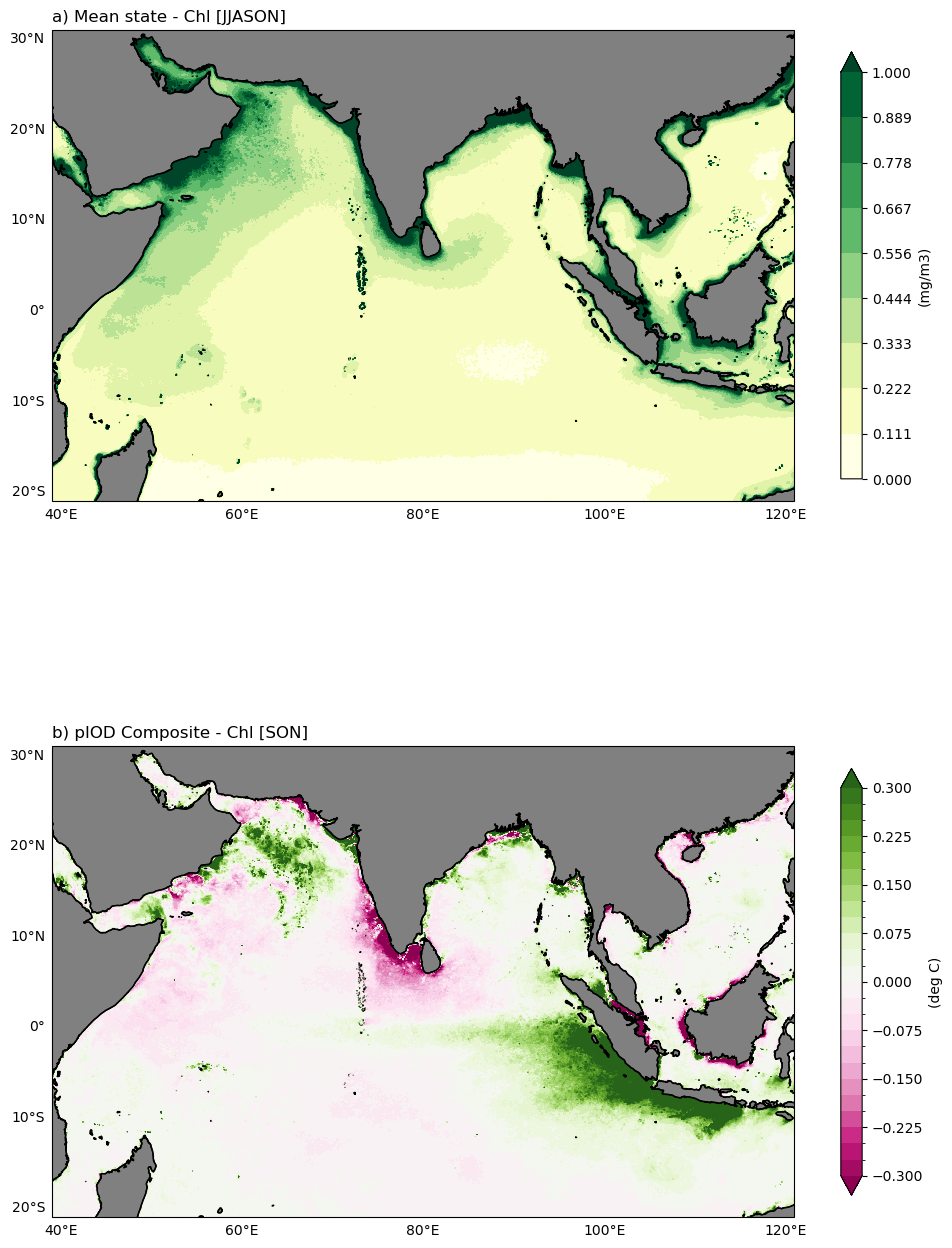

In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load and preprocess chlorophyll data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('1997-09', '2023-07'))

chl = ds.chlor_a
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

# Calculate the JJASON climatology
jjason = chl.sel(time=np.in1d(ds['time.month'], [6, 7, 8, 9, 10, 11]))
clm = jjason.groupby('time.month').mean('time')
average_chl = clm.mean('month')

# Define anomaly calculation function
def anomcal(data, a, b, c):
    clm = data.groupby('time.month').mean('time')
    data = data.groupby('time.month') - clm
    data = data.sel(time=np.in1d(data['time.month'], [a, b, c]))
    return data

chl_son = anomcal(chl, 9, 10, 11)

# Load and process SST data
fn2 = './sst.mnmean.nc'
ds_sst = xr.open_dataset(fn2)
sst = ds_sst.sst
sst = sst.sel(time=slice('1997-09', '2023-07'))

# Define detrend function
def detrend(sst, dim, deg=1):
    p = sst.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(ds_sst[dim], p.polyfit_coefficients)
    return sst - fit

# Define DMI calculation function
def dmi(sst, lat1, lat2, lon1, lon2):
    sst = sst.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    clm = sst.groupby('time.month').mean('time')
    an_sst = sst.groupby('time.month') - clm
    an_sst = an_sst.mean(('lat', 'lon'))
    an_sst = detrend(an_sst, dim='time', deg=1)
    return an_sst

wio = dmi(sst, 10, -10, 50, 70)
eio = dmi(sst, 0, -10, 90, 110)
obs_dmi = wio - eio

# Define IOD composite function
def iodcomp(index, data, c):
    STD = index.sel(time=np.in1d(index['time.month'], [6, 7, 8, 9, 10, 11])).std()
    index = index.sel(time=np.in1d(index['time.month'], [9, 10, 11]))
    index = np.where(np.abs(index) < (STD * 1), np.nan, index)
    nd = data.shape
    ds = np.empty(nd)
    for i in range(nd[0]):
        if c == 0:
            ds[i] = np.where(index[i] > 0, data[i], np.nan)
        else:
            ds[i] = np.where(index[i] < 0, data[i], np.nan)
    ds = np.nanmean(ds, axis=0)
    ds = xr.DataArray(ds, dims=['lat', 'lon'], coords=dict(lat=data.lat, lon=data.lon))
    return ds

chl_piod_compson = iodcomp(obs_dmi, chl_son, 0)

# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# First subplot: Mean state - Chl [JJASON]
ax1 = axes[0]
average_chl.plot.contourf(ax=ax1, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
ax1.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=cfeature.COLORS['land']), edgecolor='black', facecolor='gray')
ax1.coastlines(resolution='10m', linewidth=1)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xlocator = mticker.MultipleLocator(base=20)
gl1.ylocator = mticker.MultipleLocator(base=10)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
ax1.set_title('a) Mean state - Chl [JJASON]', loc='left')

# Second subplot: pIOD Composite - Chl [SON]
ax2 = axes[1]
chl_piod_compson.plot.contourf(ax=ax2, levels=25, extend='both', vmin=-0.3, vmax=0.3, cmap='PiYG', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(deg C)'})
ax2.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=cfeature.COLORS['land']), edgecolor='black', facecolor='gray')
ax2.coastlines(resolution='10m', linewidth=1)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.xlocator = mticker.MultipleLocator(base=20)
gl2.ylocator = mticker.MultipleLocator(base=10)
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
ax2.set_title('b) pIOD Composite - Chl [SON]', loc='left')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.1)  # Adjust hspace to reduce space between plots

# Show the combined plot
plt.tight_layout()
plt.show()
